# Логистическая регрессия

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

**Логистическая регрессия** --- линейный алгоритм классификации на два класса $\{0, 1\}$, основанный на подборе весов модели для оптимизации логистической функции потерь.

**Предсказания.** С помощью функции сигмоиды:
$$\sigma(t) = \frac{1}{1 + e^{-t}}$$ 
можно вычислять вероятность принадлежности объекта классу $+1$ против класса $0$ по формуле $$y_{pred} = \sigma(\langle \mathbf{x}, \mathbf{w} \rangle).$$

Значение $\langle \mathbf{x}, \mathbf{w} \rangle$, то есть выход модели до применения сигмоиды - **логит**.


**Функция потерь.** LogLoss (логистическая функция потерь). Для одного объекта:

$$
L(\mathbf{w}) = -y\, \log\,y_{pred} - (1-y)\,\log\,(1-y_{pred})
$$

Здесь

* $\mathbf{x} = (1, x_1, \ldots, x_n)$
* $y \in \{0, 1\}$ 
* $y_{pred} = \sigma(\langle \mathbf{x}, \mathbf{w} \rangle)$ -- вероятность класса $1$, предсказанная моделью
* $\mathbf{w} = (w_0, w_1, \ldots, w_n)$ 

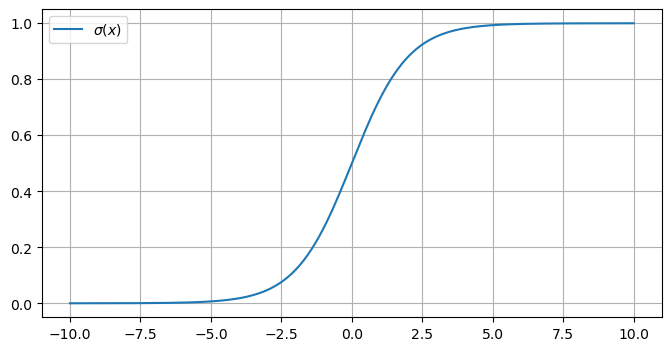

In [8]:
grid = np.linspace(-10, 10, 300)

plt.figure(figsize=(8,4))
plt.plot(grid, 1. / (1 + np.exp(-grid)), label=r'$\sigma(x)$')
plt.legend()
plt.grid(True)
plt.show();

**Градиент функции потерь для одного объекта**:
$$
\frac{\partial{L}}{\partial{\mathbf{w}}}
= \left(-\frac{y}{y_{pred}} + \frac{1-y}{1-y_{pred}}\right)\frac{\partial{y_{pred}}}{\partial{\mathbf{w}}}
$$

$$
\frac{\partial{y_{pred}}}{\partial{\mathbf{w}}} = \frac{-1}{(1+e^{-\langle \mathbf{x}, \mathbf{w} \rangle})^2} e^{-\langle \mathbf{x}, \mathbf{w} \rangle} (-\mathbf{x}) = y_{pred}(1-y_{pred})\mathbf{x}
$$

$$
\frac{\partial{L}}{\partial{\mathbf{w}}} = (y_{pred} - y) \mathbf{x}
$$

**Шаг градиентного спуска для всей матрицы $X$**:

$$
\frac{\partial{L}}{\partial{\mathbf{w}}} = \frac{1}{\ell}((\mathbf{y}_{pred} - \mathbf{y})^TX)^T = \frac{1}{\ell}X^T(\mathbf{y}_{pred} - \mathbf{y}).
$$


**Шаг градиентного спуска**:
$$\mathbf{w} := \mathbf{w} - \alpha \frac{\partial{L}}{\partial{\mathbf{w}}}.$$



## Свой класс логистической регрессии

In [9]:
class MyLogisticRegression(object):
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None


    def sigmoid(self, t):
        return 1. / (1 + np.exp(-t))


    def grad(self, X, y_true, y_pred):
        l = X.shape[0]
        grad = X.T @ (y_pred - y_true) / l

        return grad


    def fit(self, X, y, max_iter=100, lr=0.1):
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]
        l, n = X.shape
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        weights = np.random.randn(n+1, 1)

        losses = []

        for iter_num in range(max_iter):
            logits = X @ weights
            y_pred = self.sigmoid(logits)
            grad = self.grad(X, y, y_pred)
            weights -= grad * lr

            loss = self.loss(y, y_pred)
            losses.append(loss)

        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict_proba(self, X):
        X = np.array(X)
        X = np.hstack([np.ones([X.shape[0], 1]), X]) 
        weights = np.concatenate([self.intercept_.reshape(-1, 1), self.coef_], axis=0)
        logits = (X @ weights) 

        return self.sigmoid(logits)


    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold


    def loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

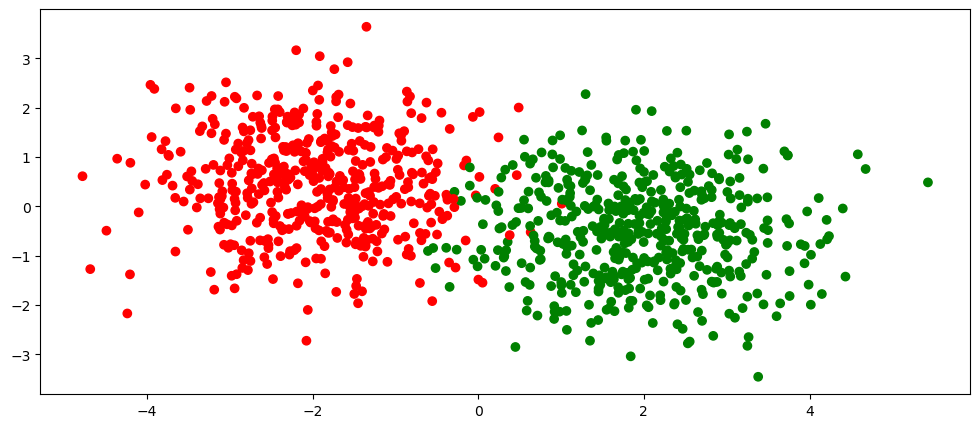

In [13]:
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[2,-0.5]], cluster_std=1, random_state=52)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(12,5))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [14]:
clf = MyLogisticRegression()

losses = clf.fit(X, y, max_iter=1000)

coef, intercept = clf.coef_, clf.intercept_

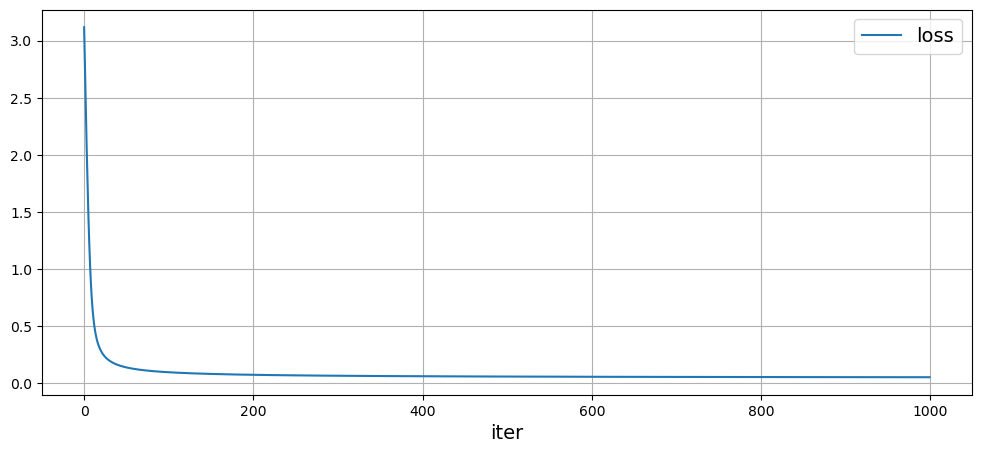

In [17]:
plt.figure(figsize=(12,5))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()
plt.show()

In [18]:
coef, intercept

(array([[ 3.27718248],
        [-0.75231857]]),
 array([0.05907703]))

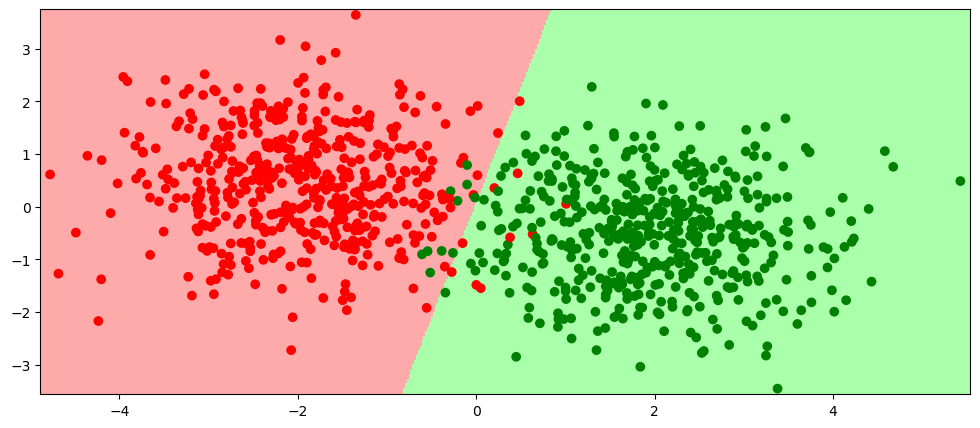

In [21]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(12,5))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))


Z = clf.predict(np.stack([xx.ravel(), yy.ravel()]).T)

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

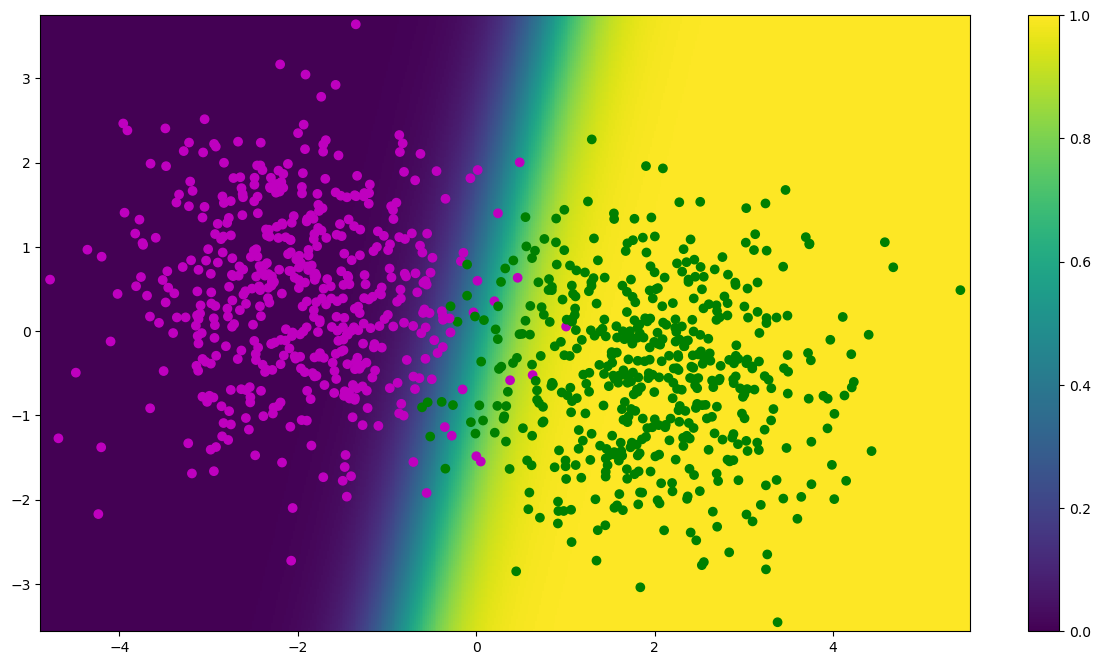

In [24]:
colors = ("magenta", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])


plt.figure(figsize=(15,8))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.colorbar()
plt.show()

In [26]:
accuracy_score(y, clf.predict(X))

0.98